# EchoSpike

In [7]:
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from utils import test
from data import load_classwise_PMNIST, load_classwise_NMNIST
from model import EchoSpike, simple_out
import numpy as np
import torch
import seaborn as sns
from scipy.signal import savgol_filter
import pickle
from main import Args

color_list = sns.color_palette('muted')
device = 'cpu'
folder = 'models/'
model_name = folder + 'nmnist_3layer_paper_2.pt'
with open(model_name[:-3] + '_args.pkl', 'rb') as f:
    args = pickle.load(f)
    args.device = device
# args = Args()
print(vars(args))

{'model_name': 'nmnist_3layer_paper_2', 'dataset': 'nmnist', 'online': False, 'device': 'cpu', 'recurrency_type': 'none', 'lr': 0.001, 'epochs': 300, 'batch_size': 64, 'n_hidden': [512, 512, 512], 'beta': 0.9, 'n_inputs': 2312, 'n_outputs': 10, 'n_time_bins': 10}


## Dataset
N-MNIST 


(34, 34, 2)


/home/lars/ownCloud/ETH/Master/Project_2/SNN_CLAPP/data.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


torch.Size([10, 1, 2312]) Target Digit: 4


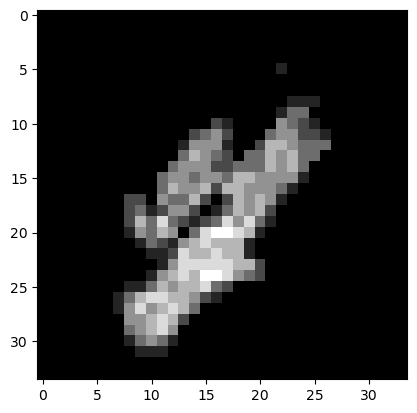

In [3]:
if args.dataset == 'mnist':
    train_loader, train_loader2, test_loader = load_classwise_PMNIST(args.n_time_bins, scale=args.poisson_scale, split_train=True) #load_NMNIST(n_time_bins, batch_size=batch_size)
else:
    train_loader, train_loader2, test_loader = load_classwise_NMNIST(args.n_time_bins, split_train=True)
# Plot Example
frames, target = train_loader.next_item(-1)
print(frames.shape, f'Target Digit: {target.item()}')
plt.figure()
if args.dataset == 'mnist':
    plt.imshow(frames[0].view(28,28), cmap='gray')
else:
    plt.imshow(frames.squeeze().sum(axis=0).view(2,34,34)[0], cmap='gray')

## Load pretrained model

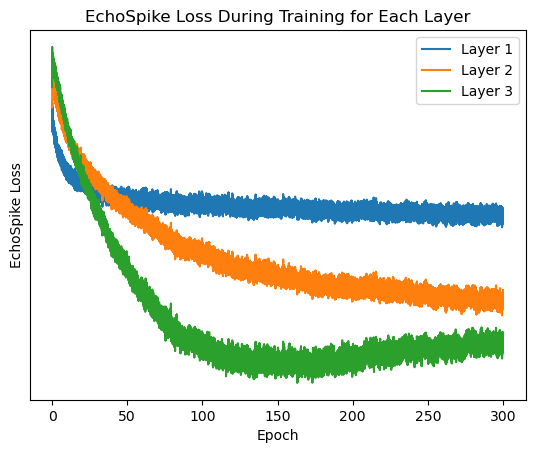

In [8]:
SNN = EchoSpike(args.n_inputs, args.n_hidden, beta=args.beta, recurrency_type=args.recurrency_type).to(device)
state_dict = torch.load(model_name, map_location=args.device)
state_dict = {key.replace('clapp', 'layers'):value for key, value in state_dict.items()}
# # overwrite the state dict
torch.save(state_dict, model_name)
SNN.load_state_dict(torch.load(model_name, map_location=device))
# Load and Plot train loss history
echo_train_losses = torch.load(f'{model_name[:-3]}_clapp_loss_hist.pt', map_location=device)
for i in range(echo_train_losses.shape[1]):
    plt.plot(np.linspace(0, args.epochs, len(echo_train_losses)), savgol_filter(echo_train_losses[:,i], 99, 1), label=f'Layer {i+1}')
plt.ylabel('EchoSpike Loss')
# no y ticks, because it's not really meaningful
plt.yticks([])
plt.xlabel('Epoch')
plt.title('EchoSpike Loss During Training for Each Layer');
plt.legend();

# Run EchoSpike on the test set and get hidden states

In [ ]:
echo_activation, target_list, echo_losses = test(SNN, test_loader, device, batch_size=args.batch_size)
print(f'EchoSpike loss per layer: {torch.stack(echo_losses).mean(axis=0).numpy()}')

Clapp loss per layer: [-0.20391022 -0.29590532 -0.33248642]


# Analyze Weights Directly

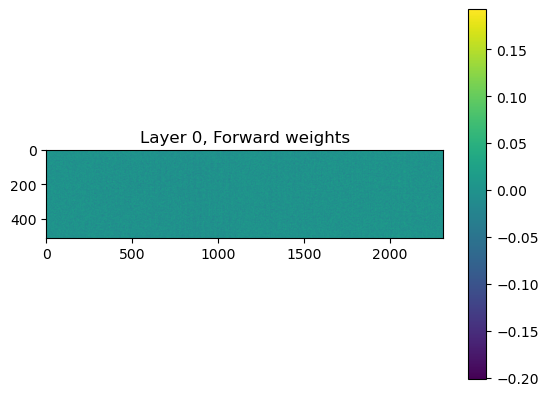

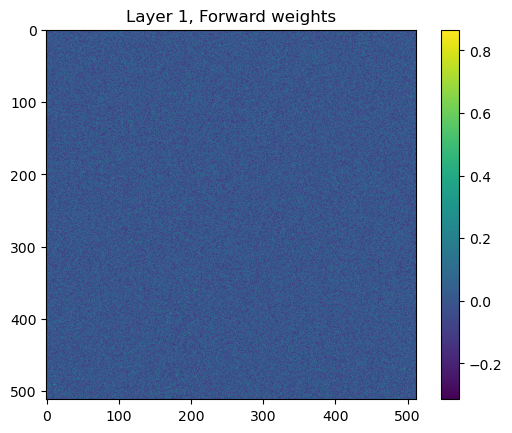

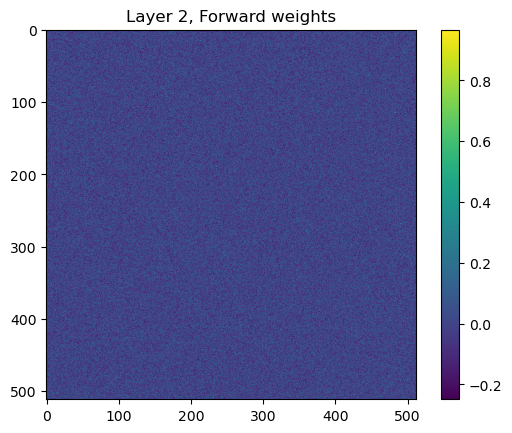

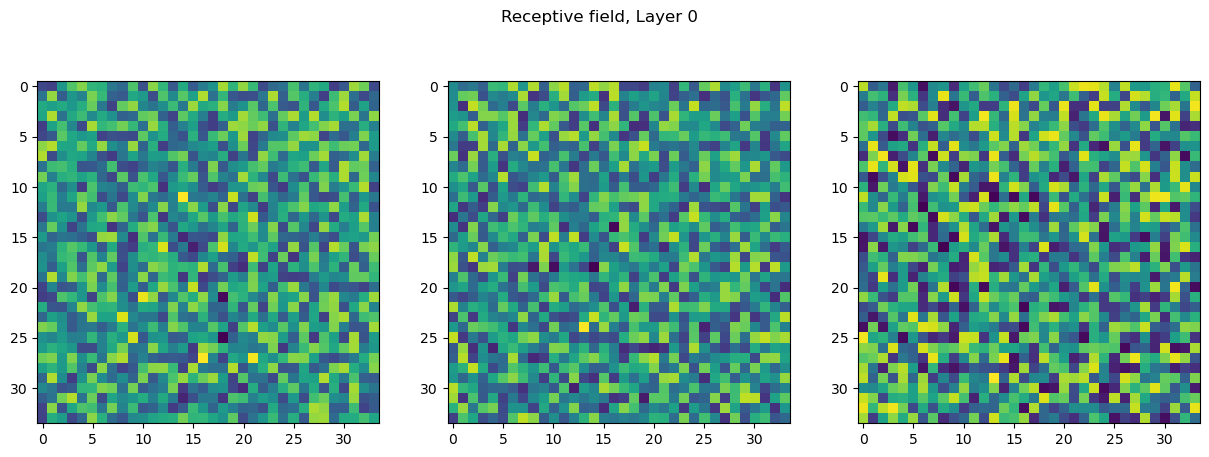

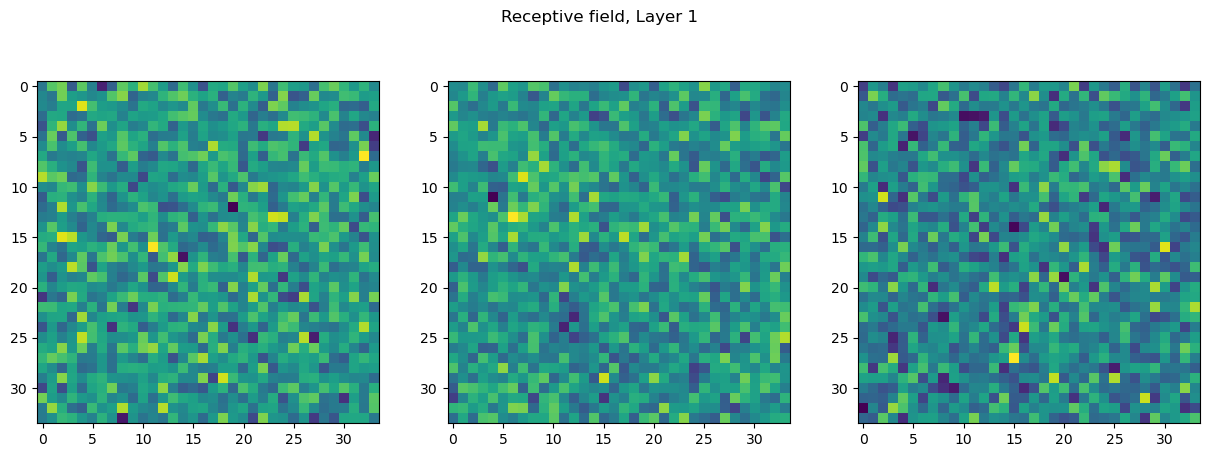

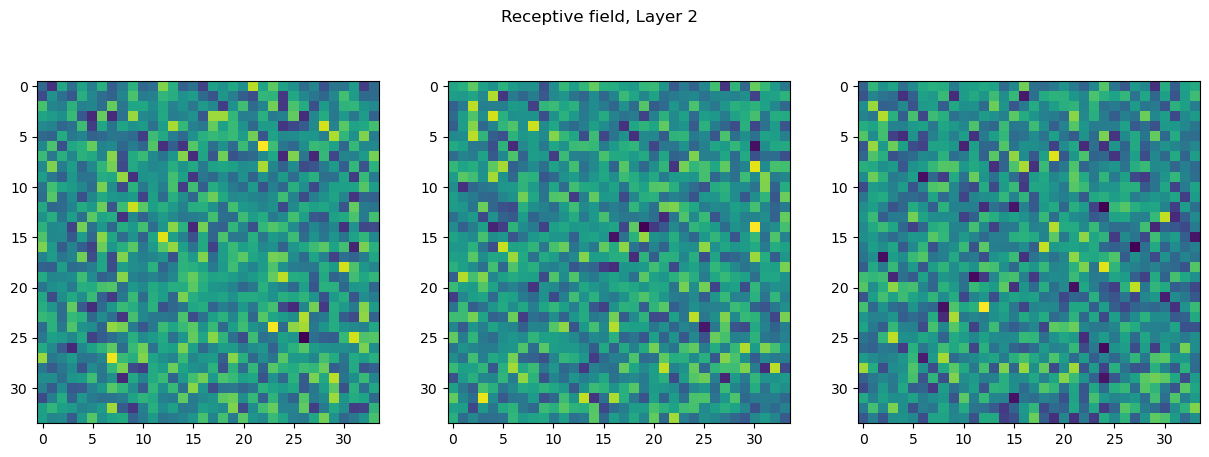

In [ ]:
layers = [SNN.layers[0].fc.weight]
for i in range(1, len(SNN.layers)):
    layers.append(SNN.layers[i].fc.weight @ layers[-1])

for i in range(len(SNN.layers)):
    plt.figure()
    plt.title(f'Layer {i}, Forward weights')
    plt.imshow(SNN.layers[i].fc.weight.detach())
    plt.colorbar()
for lidx, lay in enumerate(layers):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Receptive field, Layer {lidx}')
    for i in range(3):
        if args.dataset == 'mnist':
            axs[i].imshow(lay[i].view(28, 28).detach())
        else:
            axs[i].imshow(lay[i].view(2, 34, 34)[0].detach())

# Plot the projections of the hidden states

In [ ]:
print(len(echo_activation))
hidden_activities_transformed = [[] for i in range(len(args.n_hidden))]
for ca in echo_activation:
    for ca_layer in range(len(ca)):
        hidden_activities_transformed[ca_layer].append(ca[ca_layer])
for ha_idx in range(len(args.n_hidden)):
    hidden_activities_transformed[ha_idx] = torch.stack(hidden_activities_transformed[ha_idx]).reshape(-1, hidden_activities_transformed[ha_idx][0].shape[-1])

target_transformed = torch.stack(target_list).flatten()
print(hidden_activities_transformed[0].shape, target_transformed.shape)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# transform = TSNE()
# transform = PCA()
transform = UMAP()
colors = [color_list[i.int()] for i in target_transformed]

for hat in hidden_activities_transformed:
    # Number of Neurons that never spiked during the test set
    print(f'{(hat.sum(axis=0) == 0).sum()} dead neurons')
    hat_transform = transform.fit_transform(hat.detach().cpu().numpy())
    plt.figure(figsize=(8,8))
    col = colors
    # Plot each digit separately, this makes it easier to color and label them
    for i in range(args.n_outputs):
        col_indeces = np.argwhere(target_transformed.squeeze() == i).squeeze()
        hattt = hat_transform[col_indeces, :]
        plt.scatter(hattt[:,0], hattt[:,1], s=6, color=color_list[i], label=i, alpha=0.4)
    plt.legend()


NameError: name 'clapp_activation' is not defined

# Train output Projection From Each layer and from Inputs directly

In [31]:
from tqdm.notebook import tqdm

def train_out_proj(epochs, batch, out_projs=None):
    # train output projections from all layers (and no layer)
    dataloader = train_loader2
    losses_out = []
    optimizers = []
    print_interval = 10*batch
    if out_projs is None:
        out_projs = []
        out_proj_0 = simple_out(args.n_inputs, args.n_outputs, beta=1.0)
    else:
        for out_p in out_projs:
            out_p.train()
            out_p.reset()
        out_proj_0 = out_projs[0]
        out_projs = out_projs[1:]
    optim_0 = torch.optim.SGD(out_proj_0.parameters(), lr=1e-3)
    for lay in range(len(SNN.layers)):
        if len(out_projs) <= lay:
            out_projs.append(simple_out(args.n_hidden[-1], args.n_outputs, beta=1.0))
        optimizers.append(torch.optim.SGD(out_projs[lay].parameters(), lr=1e-3))
        optimizers[-1].zero_grad()
    SNN.eval()
    target = batch*[0]
    acc = []
    correct = (len(SNN.layers) + 1)*[0]
    with torch.no_grad():
        pbar = tqdm(total=len(dataloader)*epochs)
        while len(losses_out)*batch < len(dataloader)*epochs:
            data, target = dataloader.next_item(target, contrastive=True)
            SNN.reset(0)
            logit_lists = [[] for lay in range(len(SNN.layers)+1)]
            data = data.squeeze()
            for step in range(data.shape[0]):
                data_step = data[step].float().to(device)
                target = target.to(device)
                logits, _, _ = SNN(data_step, 0)
                if step == args.n_time_bins-1:
                    _, logts = out_proj_0(data_step, target)
                    logit_lists[0] = logts
                    for lay in range(len(SNN.layers)):
                        _, logts = out_projs[lay](logits[lay], target)
                        logit_lists[lay+1] = logts
                else:
                    out_proj_0(data_step, None)
                    for lay in range(len(SNN.layers)):
                        _, _ = out_projs[lay](logits[lay], None)
            
            preds = [logit_lists[lay].argmax(axis=-1) for lay in range(len(SNN.layers)+1)]
            # if pred.max() < 1: print(pred.max())
            dL = [preds[lay] == target for lay in range(len(SNN.layers)+1)]
            correct = [correct[lay] + dL[lay].sum() for lay in range(len(SNN.layers)+1)]
            out_proj_0.reset()
            for i, out_proj in enumerate(out_projs):
                out_proj.reset()

            losses_out.append(torch.tensor([torch.nn.functional.cross_entropy(logit_lists[lay], target.squeeze().long()) for lay in range(len(SNN.layers)+1)], requires_grad=False))

            optim_0.step()
            optim_0.zero_grad()
            for opt in optimizers:
                opt.step()
                opt.zero_grad()
            
            if len(losses_out)*batch % print_interval == 0:
                pbar.write(f'Cross Entropy Loss: {(torch.stack(losses_out)[-print_interval//batch:].sum(dim=0)/(print_interval//batch)).numpy()}\n' +
                           f'Correct: {100*np.array(correct)/print_interval}%')
                acc.append(np.array(correct)/print_interval)
                correct = (len(SNN.layers) + 1)*[0]
            pbar.update(batch)
    return [out_proj_0, *out_projs], np.asarray(acc), torch.stack(losses_out)

with torch.no_grad():
    out_projs, acc, losses_out = train_out_proj(10, args.batch_size)

  0%|          | 0/60000 [00:00<?, ?it/s]

Cross Entropy Loss: [29.449768   1.2190485  1.2354236  1.1421423]
Correct: [29.21875 74.375   74.53125 77.96875]%
Cross Entropy Loss: [7.530191  0.4400199 0.4162585 0.4126919]
Correct: [60.9375  94.375   95.15625 94.6875 ]%
Cross Entropy Loss: [3.2879684  0.3266439  0.2940977  0.28896192]
Correct: [76.875   95.625   94.84375 95.78125]%
Cross Entropy Loss: [2.4386954  0.27221048 0.24582705 0.23816986]
Correct: [80.15625 94.21875 94.84375 95.     ]%
Cross Entropy Loss: [2.1579375  0.2472966  0.21674927 0.20543203]
Correct: [79.375   95.78125 96.09375 96.09375]%
Cross Entropy Loss: [3.2148337  0.23485398 0.21564928 0.21389279]
Correct: [77.03125 94.6875  94.21875 95.     ]%
Cross Entropy Loss: [2.7444715  0.2648718  0.23453763 0.23834558]
Correct: [78.59375 93.59375 93.75    93.90625]%
Cross Entropy Loss: [1.5063503  0.22725311 0.19245693 0.18795386]
Correct: [83.90625 95.46875 96.40625 96.5625 ]%
Cross Entropy Loss: [1.283054   0.18206315 0.17145199 0.17259407]
Correct: [86.40625 95.9375

KeyboardInterrupt: 

Accuracy of last quarter: [96.59505208 98.15104167 97.64973958 97.28515625]%


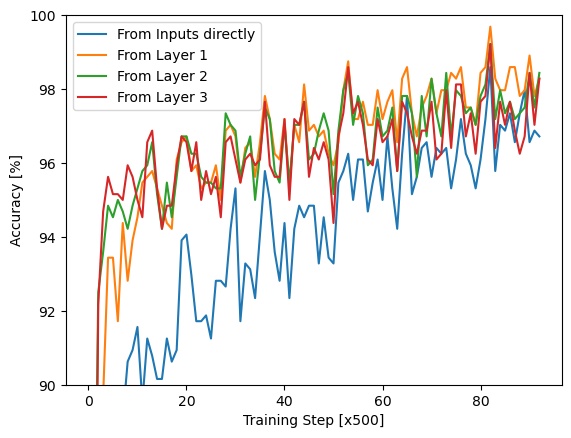

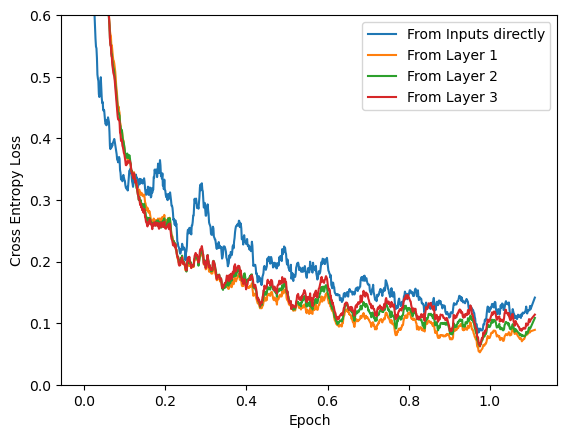

In [27]:
print(f'Accuracy of last quarter: {100*acc[-len(acc)//4:].mean(axis=0)}%')
plt.figure()
for i in range(acc.shape[1]):
    plt.plot(np.asarray(acc)[:,i]*100, color=color_list[i])
plt.ylabel('Accuracy [%]')
plt.xlabel('Training Step [x500]')
labels = ['From Inputs directly', *[f'From Layer {i+1}' for i in range(len(SNN.layers))]]
plt.legend(labels)
plt.ylim([90, 100])
plt.figure()
for i in range(losses_out.shape[1]):
    plt.plot(np.arange(len(losses_out))*args.batch_size/len(train_loader), savgol_filter(losses_out[:,i], 19, 1), label=labels[i], color=color_list[i])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylim([0, 0.6])
plt.legend();

## Test Accuracy on Test Set

  0%|          | 0/157 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 92.62%
From layer 1:
Accuracy: 95.54%
From layer 2:
Accuracy: 95.03%
From layer 3:
Accuracy: 94.95%


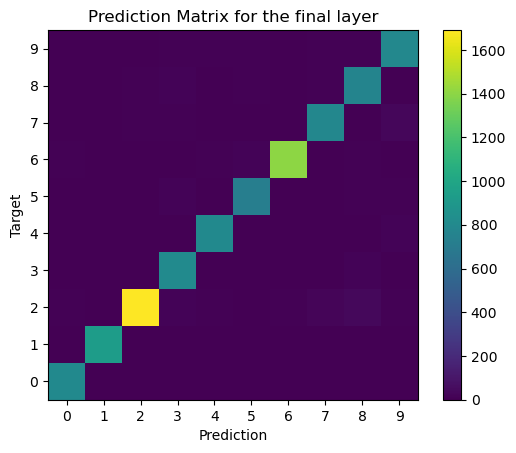

In [28]:
correct = torch.zeros(len(out_projs))
for out_proj in out_projs:
    out_proj.eval()
SNN.eval()
total = 0
pred_matrix = torch.zeros(args.n_outputs, args.n_outputs)
for idx in trange(0, len(test_loader), args.batch_size):
    for out_proj in out_projs:
        out_proj.reset()
    SNN.reset(0)
    if args.dataset == 'mnist':
        inp, target = test_loader.x[idx:idx+args.batch_size], test_loader.y[idx:idx+args.batch_size]
    else:
        until = min(args.batch_size, len(test_loader.data) - idx)
        inp = torch.stack([torch.tensor(test_loader.data[idx+i][0]).view(args.n_time_bins, -1) for i in range(until)])
        target = torch.tensor([test_loader.data[idx+i][1] for i in range(until)])
    logits = len(out_projs)*[torch.zeros((inp.shape[0],args.n_outputs))]
    for step in range(inp.shape[1]):
        data_step = inp[:,step].float().to(device)
        spk_step, _, _ = SNN(data_step, 0)
        spk_step = [data_step, *spk_step]
        for i, out_proj in enumerate(out_projs):
            out, mem = out_proj(spk_step[i], target)
            if step == args.n_time_bins-1:
                logits[i] = mem
    total += inp.shape[0]
    for i, logit in enumerate(logits):
        pred = logit.argmax(axis=-1)
        correct[i] += int((pred == target).sum())
    # for the last layer create the prediction matrix
    for j in range(pred.shape[0]):
        pred_matrix[int(target[j]), int(pred[j])] += 1
correct /= len(test_loader)
assert total == len(test_loader)
print('Directly from inputs:')
print(f'Accuracy: {100*correct[0]:.2f}%')
for i in range(len(out_projs)-1):
    print(f'From layer {i+1}:')
    print(f'Accuracy: {100*correct[i+1]:.2f}%')

plt.imshow(pred_matrix, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(args.n_outputs)])
plt.yticks([i for i in range(args.n_outputs)])
plt.colorbar();

# Few-Shot

  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 93.12%
From layer 2:
Accuracy: 94.02%
From layer 3:
Accuracy: 94.53%
Accuracy per Label: tensor([98.1663, 98.3122, 92.2056, 93.5972, 96.8675, 94.1253, 93.6258, 94.9112,
        94.1677, 92.2894])%


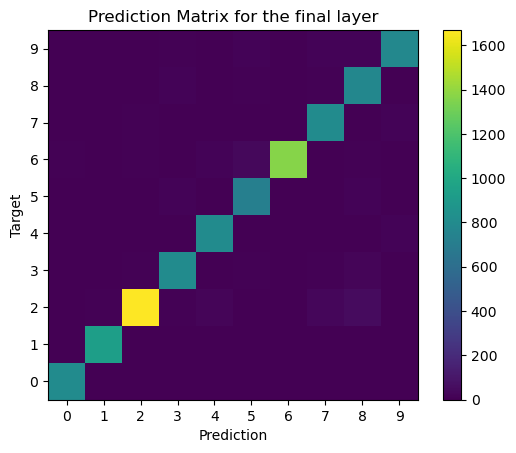

In [30]:
# Randomly select one sample of each class and save the spiking activity
SNN.reset(0)
one_shot_samples = torch.zeros(args.n_outputs, args.n_time_bins, args.n_inputs)
one_shot_spks = [torch.zeros(args.n_outputs, h) for h  in args.n_hidden]
k = 50
for i in range(args.n_outputs):
    for j in range(k):
        img, _ = train_loader2.next_item(i, contrastive=False)
        one_shot_samples[i] = img.squeeze()
        for t in range(args.n_time_bins):
            logits, _, _ = SNN(img[t].float(), 0)
            for idx, log in enumerate(logits):
                one_shot_spks[idx][i] += log.squeeze()

def metric(spk, one_shot):
    dists = torch.zeros(spk.shape[0], args.n_outputs)
    for i in range(args.n_outputs):
        one_shot_i = one_shot[i] / one_shot[i].sum()
        dists[:, i] = torch.einsum('bi, i->b' , spk, one_shot_i)
    return dists

def get_predictions(spks):
    preds = torch.zeros(len(spks), spks[0].shape[0])
    # for each layer get the prediction
    for i in range(len(spks)):
        dists = metric(spks[i], one_shot_spks[i])
        preds[i] = dists.argmax(axis=-1)
    return preds

batch = int(len(test_loader)/10)
correct_oneshot = torch.zeros(len(SNN.layers))
SNN.eval()
pred_matrix_oneshot = torch.zeros(args.n_outputs, args.n_outputs)
for idx in trange(0, len(test_loader), batch):
    SNN.reset(0)
    if args.dataset == 'mnist':
        inp, target = test_loader.x[idx:idx+batch], test_loader.y[idx:idx+batch]
    else:
        until = min(batch, len(test_loader.data) - idx)
        inp = torch.stack([torch.tensor(test_loader.data[idx+i][0]).view(args.n_time_bins, -1) for i in range(until)])
        target = torch.tensor([test_loader.data[idx+i][1] for i in range(until)])
    logits = [torch.zeros(inp.shape[0], h) for h  in args.n_hidden]
    for step in range(inp.shape[1]):
        data_step = inp[:,step].float().to(device)
        spk_step, _, _ = SNN(data_step, 0)
        for logidx in range(len(spk_step)):
            logits[logidx] += spk_step[logidx]
    preds = get_predictions(logits)
    for i in range(preds.shape[0]):
        correct_oneshot[i] += int((preds[i] == target).sum())
    # for the last layer create the prediction matrix
    for j in range(preds.shape[1]):
        pred_matrix_oneshot[int(target[j]), int(preds[-1, j])] += 1
correct_oneshot /= len(test_loader)
for i in range(len(SNN.layers)):
    print(f'From layer {i+1}:')
    print(f'Accuracy: {100*correct_oneshot[i]:.2f}%')

plt.imshow(pred_matrix_oneshot, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(args.n_outputs)])
plt.yticks([i for i in range(args.n_outputs)])
plt.colorbar();
print(f'Accuracy per Label: {100*pred_matrix_oneshot.diag()/pred_matrix_oneshot.sum(axis=1)}%') # correct axis?